In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

sns.set_style("whitegrid")

In [2]:
# Define a function to convert the dates into a readable format and prepare it for datetime conversion
def fix_date_format(date):
    '''Changes format from DD.MM.YYYY to YYYY-MM-DD'''
    return (date[-4:] + '-' + date[3:5] + '-' + date[:2])

In [3]:
# Import the training data
training_df = pd.read_csv('sales_train_v2.csv')

# Import the items dataset
items_df = pd.read_csv('items.csv')

# Import the item_categories.csv dataset with the item_category_id as the index
items_cat_df = pd.read_csv('item_categories.csv', index_col = 'item_category_id')

# Import the shops.csv dataset with the shop_id as the index
shops_df = pd.read_csv('shops.csv', index_col = 'shop_id')

# Import the test.csv dataset with the ID as the index
test = pd.read_csv('test.csv', index_col = 'ID')

# Import the sample_submission.csv dataset with the ID as the index
sample = pd.read_csv('sample_submission.csv', index_col = 'ID')

In [4]:
# Convert the date column to a datetime object.
training_df['date'] = training_df['date'].apply(fix_date_format)
datetime_conversion = pd.to_datetime(training_df['date'])
training_df['date'] = datetime_conversion

In [5]:
# Remove outliers in the item_price from our dataset.
training_df = training_df[(training_df['item_price'] != 307980.0) & (training_df['item_price'] >= 0)]

# Create another dataset with all negative values in item_cnt_day removed in case we want to use it.
no_negative_df = training_df[training_df['item_cnt_day'] >= 0]

First, we'll work with our training_df (with negative values in the item_cnt_day).

In [21]:
# Since we're excluding the item category and shop names, we only need two datasets: training_df and items_df

# The items dataset has 22170 unique item ids whereas the training dataset only has 21806 unique item ids
# We'll address this by using an outer merge and filling in the necessary null values with the mode of each column
training_merge_df = training_df.merge(items_df, on='item_id', how='right')

# We'll also remove the item_name column here.
training_merge_df.drop('item_name', axis=1, inplace=True)

# Fill in the null values with the mode of each column
for col in training_merge_df:
    training_merge_df[col].fillna(training_merge_df[col].mode()[0], inplace=True) 
    
training_merge_df[['date_block_num', 'shop_id']] = training_merge_df[['date_block_num', 'shop_id']].astype(int)

In [22]:
# For later analysis, we may want to use only the month or month + year for analysis (provides cylical data)
# We'll make new columns here for both the month and year.

training_merge_df['month'] = training_merge_df['date'].dt.month
training_merge_df['year'] = training_merge_df['date'].dt.year

In [26]:
# Since we have entries with dates, we'll go ahead and a time series plot with it.
# We'll construct plots for 3 random shops to check for performance and also plot the mean of them.

# First we need to construct a list to define our x-axis
x_label = '2013-01 2013-05 2013-09 2014-01 2014-05 2014-09 2015-01 2015-05 2015-09'.split(' ')

# First Plot: shop_id = 10
shop_10 = training_merge_df[training_merge_df['shop_id'] == 10].groupby('date')['item_cnt_day'].sum()
resamp_10 = shop_10.resample('M', label='left').sum()

# Second Plot: shop_id = 24
shop_24 = training_merge_df[training_merge_df['shop_id'] == 24].groupby('date')['item_cnt_day'].sum()
resamp_24 = shop_24.resample('M', label='left').sum()

# Third Plot: shop_id = 50
shop_50 = training_merge_df[training_merge_df['shop_id'] == 50].groupby('date')['item_cnt_day'].sum()
resamp_50 = shop_50.resample('M', label='left').sum()

# Mean Plot:
combined_shops = pd.DataFrame([resamp_10, resamp_24, resamp_50]).T
combined_shops.columns = ['shop_10', 'shop_24', 'shop_50']
combined_shops['average'] = combined_shops.mean(axis=1)

Text(0.5,1,'Total items sold monthly')

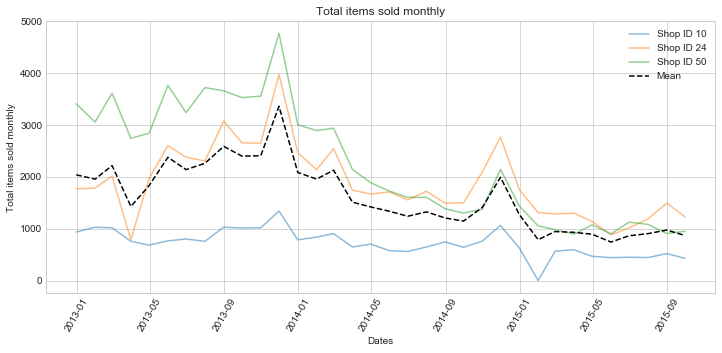

In [27]:
# Plot all three plots and the mean plot on one figure 
plt.figure(figsize=(12, 5))

plt.plot(resamp_10, alpha=0.5)
plt.plot(resamp_24, alpha=0.5)
plt.plot(resamp_50, alpha=0.5)
plt.plot(combined_shops['average'], c='black', linestyle='--')

plt.legend(['Shop ID 10', 'Shop ID 24', 'Shop ID 50', 'Mean'])
plt.xticks(rotation=60)
plt.xticks(x_label)

plt.xlabel('Dates')
plt.ylabel('Total items sold monthly')
plt.title('Total items sold monthly')

Some things to takeaway from this plot is that overall sales are declining over time (2013 > 2014 > 2015 > ...). However, there is a reoccuring peak at December for both years. This indicates there is likely a seasonal event that promotes sales around that. I also appears that, in general, all stores follow this trend.

Text(0.5,1,'Total items sold across all shops per month')

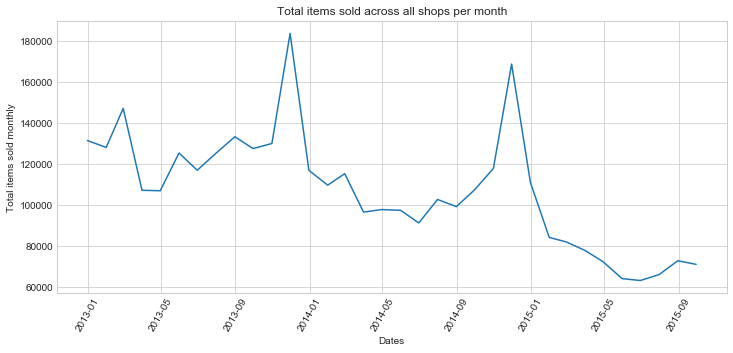

In [28]:
# We'll go ahead and plot the total sales of all the shops next to observe the trend.

# Let's define the dataframe for the plot here
sum_shops_df = training_merge_df.groupby('date')['item_cnt_day'].sum().resample('M', label='left').sum()

# Plot the data
plt.figure(figsize=(12,5))
plt.plot(sum_shops_df)
plt.xticks(rotation=60)
plt.xticks(x_label)
plt.xlabel('Dates')
plt.ylabel('Total items sold monthly')
plt.title('Total items sold across all shops per month')

Text(0.5,1,'Average items sold monthly')

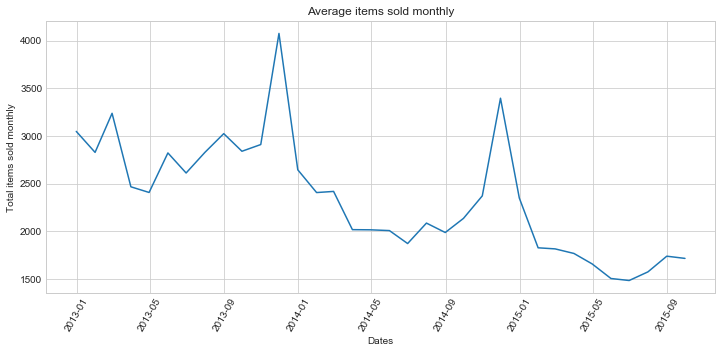

In [29]:
# We'll also plot the mean sales of all the shops

# Let's define the dataframe for the mean sales here
mean_shops_df = training_merge_df.groupby(['date', 'shop_id'])['item_cnt_day'].sum()
mean_shops_df = mean_shops_df.groupby('date').mean().resample('M', label='left').sum()

# Plot the data
plt.figure(figsize=(12,5))
plt.plot(mean_shops_df)
plt.xticks(rotation=60)
plt.xticks(x_label)
plt.xlabel('Dates')
plt.ylabel('Total items sold monthly')
plt.title('Average items sold monthly')

It looks like the plots with all shops supports that sales have declined over the years, but there are still peaked sales on December.

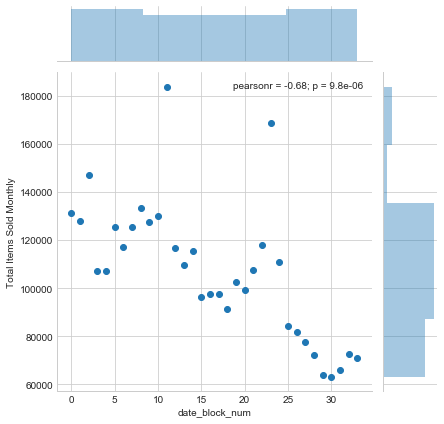

In [30]:
# Since our target variable will be item_cnt_day (or rather item_cnt_month since we'll be working with monthly data), we'll
# plot jointplots and barplots to observe the correlation between item_cnt_month with a multitude of other variables.
# We'll also be using histograms to observe the distribution of the sales


# First we'll check out a general progression sales with time using date_block_num

# Define the dataframe
date_block_df = training_merge_df.groupby('date_block_num')[['item_cnt_day']].sum()
date_block_df.columns = ['Total Items Sold Monthly']

# Plot the jointplot
sns.jointplot(x=date_block_df.index, y=date_block_df['Total Items Sold Monthly'], kind = 'scatter')

Text(0,0.5,'Frequency')

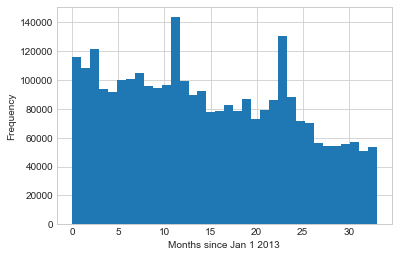

In [31]:
# Plot the histogram
plt.hist(training_merge_df['date_block_num'],bins=34)
plt.xlabel('Months since Jan 1 2013')
plt.ylabel('Frequency')

# From the histogram, we see similar patterns to the time-series plots from before

Text(0,0.5,'Frequency')

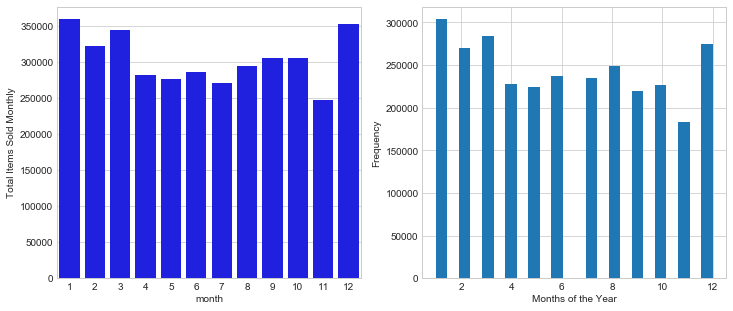

In [32]:
# Next let's take a look at the months. This will give us a bettr idea of cyclical patterns.
month_df = training_merge_df.groupby('month')[['item_cnt_day']].sum()
month_df.columns = ['Total Items Sold Monthly']

# Define the subplot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

# Plot the barplot
sns.barplot(x=month_df.index, y=month_df['Total Items Sold Monthly'], color='b', ax=ax1)

# Plot the histogram
ax2.hist(training_merge_df['month'], bins=24)
ax2.set_xlabel("Months of the Year")
ax2.set_ylabel("Frequency")

# Note: I used 24 bins so that there are distinct divisions in the plot so it's easier to observe

# It appears that the bar plot and histogram can be misleading. Our data only goes up to Oct 2015, which means
# that there is no data for months 11 and 12. This causes a huge drop in value for these two months.

Text(0,0.5,'Frequency')

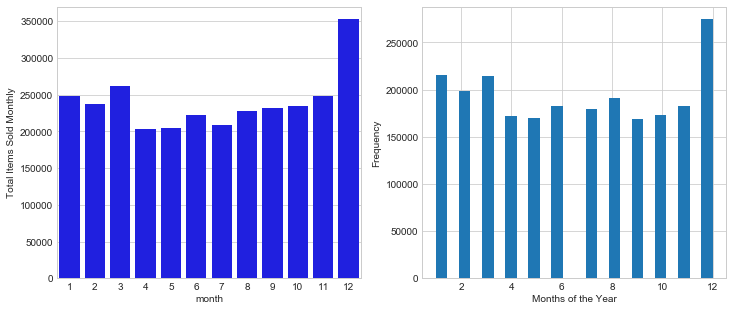

In [33]:
# Since the two previous plots are misleading, I will redo the plots with data between 2013-2014.

# Let's make a new dataset here
month_cut_df = training_merge_df[training_merge_df['year'] != 2015].groupby('month')[['item_cnt_day']].sum()
month_cut_df.columns = ['Total Items Sold Monthly']

# Define the subplot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

# Plot the barplot
sns.barplot(x=month_cut_df.index, y=month_cut_df['Total Items Sold Monthly'], color='b', ax=ax1)

# Plot the histogram
ax2.hist(training_merge_df[training_merge_df['year'] != 2015]['month'],bins=24)
ax2.set_xlabel('Months of the Year')
ax2.set_ylabel('Frequency')

# From this, we can see that December has far more purchases (number of entries and number of items bought per entry)
# Other than that, there doesn't appear to be a drastic decline in number of entries throughout the year (histogram),
# but there is a significant total number of items bought (less items per entry)(jointplot)

Text(0,0.5,'Frequency')

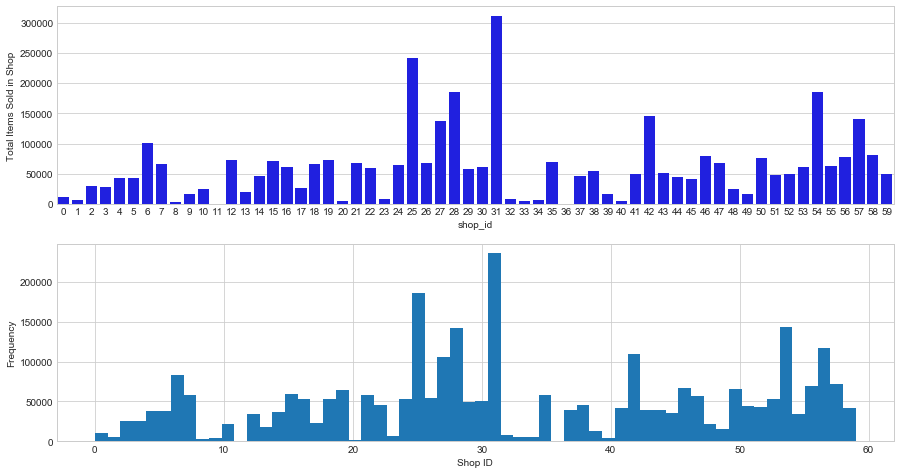

In [34]:
# Next we'll take a look at shop performance.
shop_id_df = training_merge_df.groupby('shop_id')[['item_cnt_day']].sum()
shop_id_df.columns = ['Total Items Sold in Shop']

# Define the subplot
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15, 8))

# Plot the barplot
sns.barplot(x=shop_id_df.index, y=shop_id_df['Total Items Sold in Shop'], color='b', ax=ax1)

# Plot the histogram
ax2.hist(x=training_merge_df['shop_id'], bins=60)
ax2.set_xlabel('Shop ID')
ax2.set_ylabel('Frequency')

# From the looks of the data, (in the span of the 2 years) some shops performed significantly better than others.
# However, we don't have to worry about this as we'll be addressing this with regression towards the mean in our model.

Text(0,0.5,'Frequency')

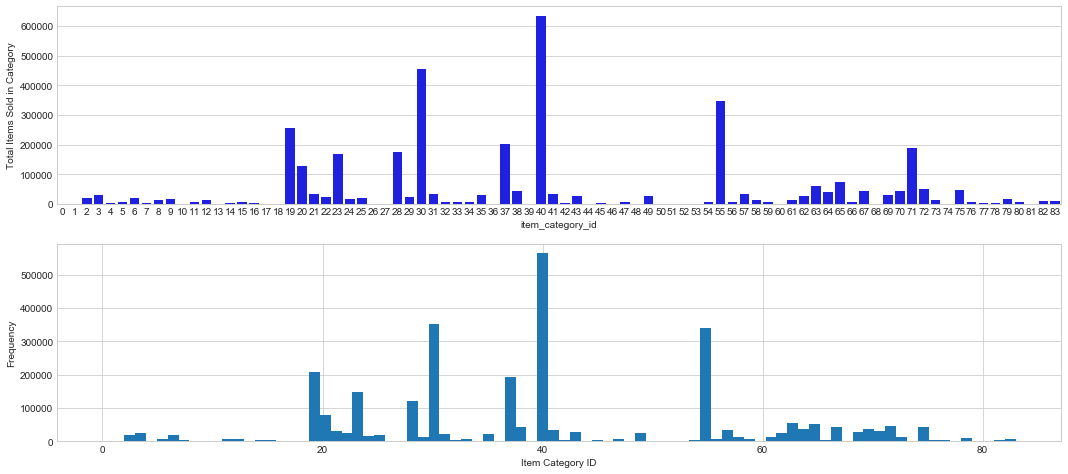

In [35]:
# Next we'll take a look at item_category_id
item_cat_df = training_merge_df.groupby('item_category_id')[['item_cnt_day']].sum()
item_cat_df.columns = ['Total Items Sold in Category']

# Define the subplot
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(18, 8))

# Plot the barplot
sns.barplot(x=item_cat_df.index, y=item_cat_df['Total Items Sold in Category'], color='b', ax=ax1)

# Plot the histogram
ax2.hist(training_merge_df['item_category_id'], bins=84)
ax2.set_xlabel('Item Category ID')
ax2.set_ylabel('Frequency')

# Both the histogram and the barplots appear similar. However, we see much larger discrepancies in the categories

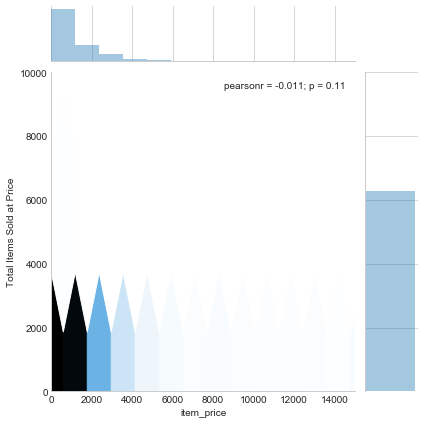

In [36]:
# Lastly we'll look at the effects of item_price
item_price_df = training_merge_df.groupby('item_price')[['item_cnt_day']].sum()
item_price_df.columns = ['Total Items Sold at Price']

# Plot the barplot
sns.jointplot(x=item_price_df.index, y=item_price_df['Total Items Sold at Price'], kind='hex', xlim=(0,15000), ylim=(0, 10000))

# The original plot has x-axis (0 - 70,000) and y-axis (0 - 300,000)
# We can see that sales being to decline drastically after item price 5000.

Text(0,0.5,'Frequency')

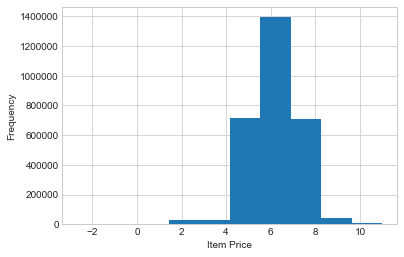

In [37]:
# Plot the histogram with a logarithmic scale
plt.hist(np.log(training_merge_df['item_price']))
plt.xlabel('Item Price')
plt.ylabel('Frequency')

# Interestingly enough, it looks most of the entries occur at approximate item_price = 403 (e ^ 6) and the distribution is 
# fairly normal around that point

Of all the variables explored here, it sems like item_price and month may be the best predictors of items sold. Although item_price doesn't have a significant correlation with items sold, it does tell us the price range where most purchases are generally made. 

For the shop_id and item_category_id, we can observe how some shops perform significantly better than others. This gives us the choice of grouping some of the lower performing shops/item categories together for our model. This also helps reduce the amount of dummy variables we'll need to work with which reduces the computational intensity.

Although we won't be exploring this in our analysis here, an interesting question to ask is the cause for the decline in sales. A hypothesis is that the data isn't continually updated with new items (ex. PS3s were popular in 2013, but not so much in the later years as more consoles arrived). Specific items could have also been removed from shop shelves which wouldn't be reflected in the provided data. This would suggest that the decline is sales could just be movement from one trend to the next. However, if that was the case, what drives the sales so much in December of every year? 

Similar questions can be asked about shop performance. Why do some shops perform so much better than others? We haven't personally seen any of the explored shops, but if a shop closed down within the 2.5 year timespan (which is common for smaller, local stores), we would see overall low performance in those shops.

In [38]:
training_merge_df[['item_id', 'item_category_id', 'shop_id']].nunique()

item_id             22170
item_category_id       84
shop_id                60
dtype: int64

The next steps would be to check for significant difference between the shops and then between the item categories. Although our test data actually utilizes item id and not item category id, it would be unrealistic to test on 21,806 unique item ids. As a result, we'll use the group category id even though there may be significant discrepncies within the category itself. In addition, we'll be further grouping the item category ids and shop ids into smaller groups so that it's less computationally intensive. We'll group similarly performing ids together and test for significance compared to other groups that performed different. By testing for significance, we will be validating our groupings.

### Shop ID Groupings: (p < 0.05)
Null Hypothesis: All the groups are the same

Alternative Hypothesis: The groups are all statistically different from each other


### Item Category ID Groupings: (p < 0.05)

Null Hypothesis: All the groups are the same

Alternative Hypothesis: The groups are all statistically different from each other


*Note: We'l check for statistical difference between the closest groupings and use that generalize the rest.

Text(0.5,1,'Shop Performance')

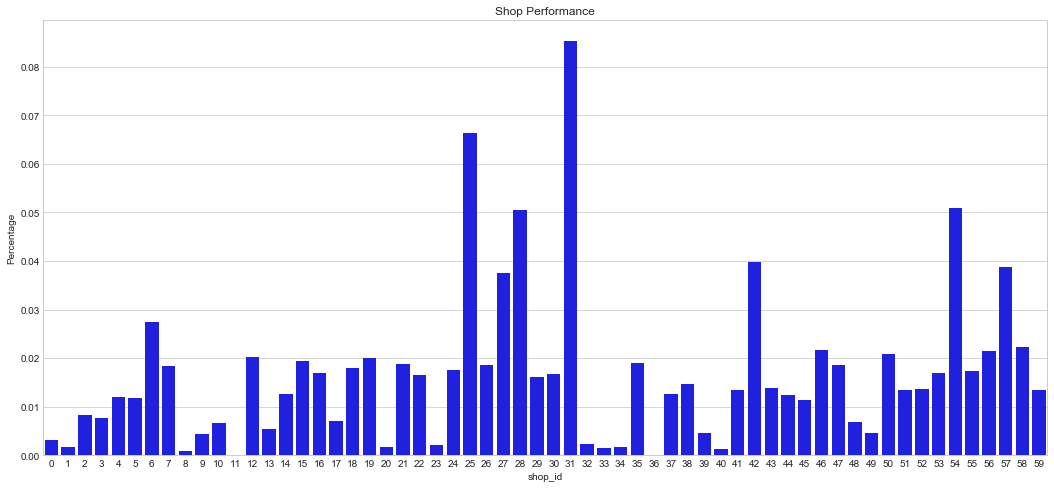

In [39]:
# We'll first do the groupings for shop_id

percentage = shop_id_df['Total Items Sold in Shop'] / np.sum(shop_id_df['Total Items Sold in Shop'])

# First we'll plot a barplot of the data normalized to 1
plt.figure(figsize=(18,8))
sns.barplot(x=shop_id_df.index,
            y=percentage, color='b')
plt.ylabel('Percentage')
plt.title('Shop Performance')

In [40]:
# Define a column for percentage of total items sold
shop_id_df['Percentage of Total'] = percentage

In [41]:
# Define the groupings for the shop_id
cut_offs = np.arange(0, 0.031, 0.005)
shop_groups = {}
for i in range(len(cut_offs) - 1):
     shop_groups[i] = shop_id_df[(shop_id_df['Percentage of Total'] > cut_offs[i]) & 
                                 (shop_id_df['Percentage of Total'] <= cut_offs[i+1])]
shop_grouped = pd.concat(shop_groups)
# Note: There are 5 groupings + 8 standalone shops that performed above the rest. This gives us a total of 13 shop_ids

In [42]:
# Reset the index so we can do groupbys
shop_inter_group = shop_grouped.reset_index()

# Define a dataframe with the grouped shops added together
shop_sum_group = shop_inter_group.groupby('level_0')[['Total Items Sold in Shop', 'Percentage of Total']].sum()

# Define a dataframe with the grouped shops averaged
# inter_mean_group = inter_group.groupby('level_0')[['Percentage of Total']].mean()

Text(0.5,1,'Performance of Grouped or Standalone Shops')

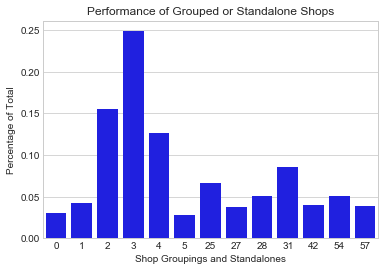

In [43]:
# Concatenate the grouped shops with the standalones.
grouped_shop_df = pd.concat([shop_sum_group,shop_id_df[shop_id_df['Percentage of Total'] > 0.03]])

sns.barplot(x=grouped_shop_df.index,
            y=grouped_shop_df['Percentage of Total'], color='b')
plt.xlabel('Shop Groupings and Standalones')
plt.title('Performance of Grouped or Standalone Shops')

In [44]:
# Let's check for statistical difference between the groupings
for i in range(max(shop_inter_group['level_0'])-1):
    t_score = stats.ttest_ind(shop_inter_group[shop_inter_group['level_0'] == i]['Percentage of Total'],
                              shop_inter_group[shop_inter_group['level_0'] == i+1]['Percentage of Total'])
    print ('T-score between Group {} and Group {}: {} \n'.format(i, i+1, t_score)) 

# From the t-scores, we can see that our groups are statistically different.

T-score between Group 0 and Group 1: Ttest_indResult(statistic=-7.178042539769341, pvalue=1.1072625837435034e-06) 

T-score between Group 1 and Group 2: Ttest_indResult(statistic=-12.036483213381134, pvalue=1.9689112719678937e-09) 

T-score between Group 2 and Group 3: Ttest_indResult(statistic=-11.992597777105942, pvalue=1.2659359043441033e-11) 

T-score between Group 3 and Group 4: Ttest_indResult(statistic=-6.7669552889372016, pvalue=2.4358517996002186e-06) 



Text(0.5,0,'item category id')

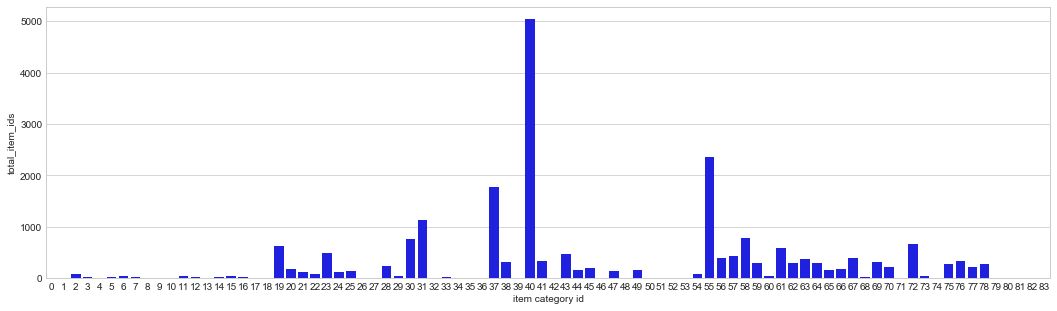

In [45]:
# Plot the distribution of item ids in item category ids

# Create a dictionary with the count of unique ids in each item category
item_cat_dict = {}

for i in range(84):
    item_cat_dict[i] = training_merge_df[training_merge_df['item_category_id'] == i]['item_id'].nunique()

# Convert the dictionary to a dataframe
item_cat_dist = pd.DataFrame.from_dict(item_cat_dict, orient='index')
item_cat_dist.columns = ['total_item_ids']

# Plot the barplot
plt.figure(figsize=(18, 5))
sns.barplot(x=item_cat_dist.index, y=item_cat_dist['total_item_ids'], color='b')
plt.xlabel('item category id')

It appears that the item ids are poorly distributed within the item categories
The main thing to note is that item_category_id = 40 has the most unique item ids, and is the highest performing category
This suggests that the high performance can simply be due to the amount of unique item ids.
Item categories is a very poor choice to use in replacement of item ids.
Instead, we will use grouped item_ids.

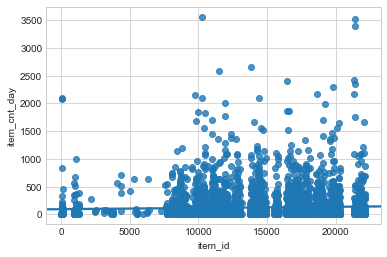

In [46]:
# Let's explore the distribution of item id performance in item category id 40 using a scatter plot
item_cat_40 = training_merge_df[training_merge_df['item_category_id'] == 40]
item_cat_40 = item_cat_40.groupby('item_id')[['item_cnt_day']].sum()

# Plot the scatterplot
item_cat_40.reset_index(inplace=True)
sns.regplot(x =item_cat_40['item_id'], y=item_cat_40['item_cnt_day'])

# There is a large amount of variation in item id performance within a single item category

In [47]:
item_cat_40.describe()

,item_id,item_cnt_day
count,5035.000000,5035.000000
mean,14341.649652,125.966634
std,4658.748299,255.842605
min,0.000000,1.000000
25%,10749.500000,12.000000
50%,14427.000000,44.000000
75%,18131.000000,111.000000
max,22163.000000,3563.000000


In [48]:
# Make groups from the item id themselves instead of creating weighted items in each category
item_id_df = training_merge_df.groupby('item_id')[['item_cnt_day']].sum()
item_id_df.reset_index(inplace=True)

In [49]:
# Define the cutoffs for the item ids
cut_offs = [np.arange(0, 110, 10), np.arange(100, 250, 50), np.arange(200, 1200, 200), np.arange(1000, 3500, 500)]

# Create a dataframe with all the item ids that sold a grand total of less than 0
orig_df = item_id_df[item_id_df['item_cnt_day'] <= 0].copy()
orig_df['group'] = -1

# Create the grouped dataframes and combine it with the negative dataframe
for i in range(len(cut_offs)):
    for j in range(len(cut_offs[i])-1):
        item_id_groups = item_id_df[(item_id_df['item_cnt_day'] >= cut_offs[i][j]) & 
                                       (item_id_df['item_cnt_day'] < cut_offs[i][j+1])].copy()
        item_id_groups['group'] = (orig_df['group'].max() + 1)
        orig_df = pd.concat([orig_df, item_id_groups])


In [50]:
# Create the dataframe of standalones
standalone_id = item_id_df[item_id_df['item_cnt_day'] >= 3000].copy()

# Assign the item_ids as the group column
standalone_id['group'] = standalone_id['item_id']

# Concatenate the groups and the standalones
grouped_item_df = pd.concat([orig_df, standalone_id])
grouped_item_df.columns = ['item_id', 'item_cnt', 'item_group']

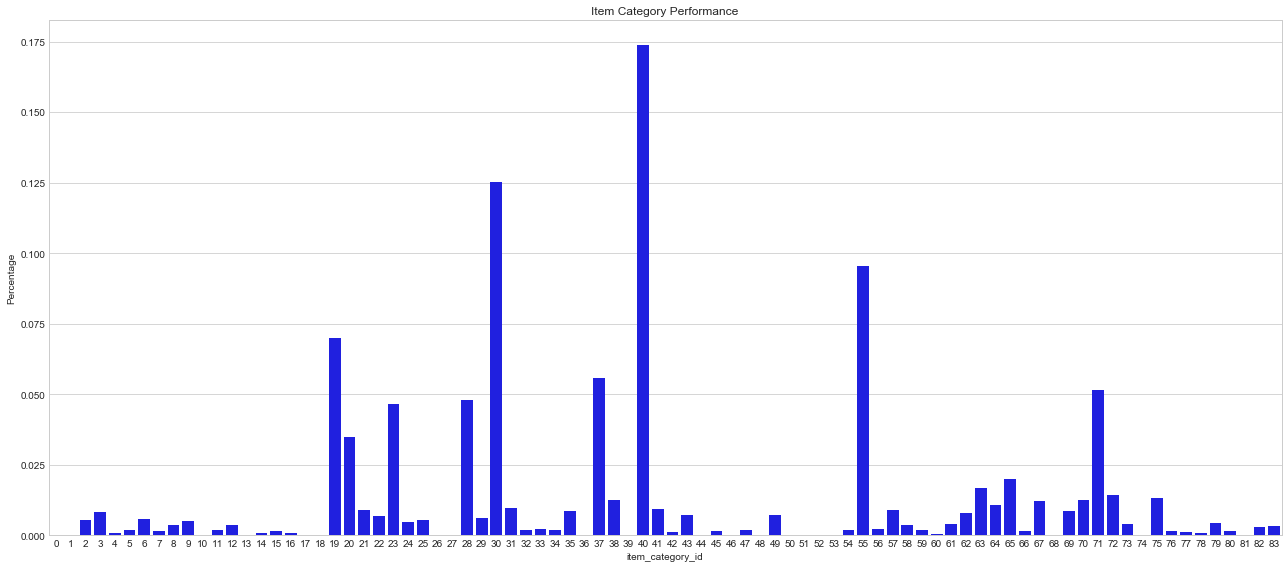

In [51]:
# Now let's make the groupings for item_category_id
percentage = item_cat_df['Total Items Sold in Category'] / np.sum(item_cat_df['Total Items Sold in Category'])

# Define another column for the percentages
item_cat_df['Percentage of Total'] = percentage

# First we'll plot a barplot of the data normalized to 1
plt.figure(figsize=(18,8))
sns.barplot(x=item_cat_df.index,
            y=percentage, color='b')
plt.ylabel('Percentage')
plt.title('Item Category Performance')
plt.tight_layout()

In [52]:
# Define the grouping pairs
item_cat_pairs = [(0, 0.0015), (0.0015, 0.003), (0.003, 0.0045), (0.0045, 0.006), (0.006, 0.01), (0.01, 0.015)]

# Initialize an empty dictioanry that will hold the grouped dataframes
item_cat_groups = {}

for i, (j, k) in enumerate(item_cat_pairs):
    item_cat_groups[i] = item_cat_df[(item_cat_df['Percentage of Total'] <= k) & 
                                     (item_cat_df['Percentage of Total'] > j)]

# Concatenate the grouped dataframes together
item_cat_grouped = pd.concat(item_cat_groups)

In [53]:
# Reset the index so we can do groupbys
cat_inter_group = item_cat_grouped.reset_index()

# Define a dataframe with the grouped shops added together
cat_sum_group = cat_inter_group.groupby('level_0')[['Total Items Sold in Category', 
                                                    'Percentage of Total']].sum()

# Note: There are 6 groupings + 11 standalone categories that performed above the rest. This gives us a total of 17 item_category_id

Text(0.5,1,'Performance of Grouped or Standalone Item Categories')

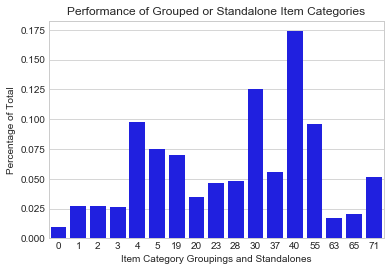

In [54]:
# Concatenate the grouped item categories with the standalones.
grouped_cat_df = pd.concat([cat_sum_group,item_cat_df[item_cat_df['Percentage of Total'] > 0.015]])

sns.barplot(x=grouped_cat_df.index,
            y=grouped_cat_df['Percentage of Total'], color='b')
plt.xlabel('Item Category Groupings and Standalones')
plt.title('Performance of Grouped or Standalone Item Categories')

In [55]:
# Let's check for statistical difference between the groupings
for i in range(5):
    t_score = stats.ttest_ind(cat_inter_group[cat_inter_group['level_0'] == i]['Percentage of Total'],
                              cat_inter_group[cat_inter_group['level_0'] == i+1]['Percentage of Total'])
    print ('T-score between Group {} and Group {}: {} \n'.format(i, i+1, t_score)) 

# From the t-scores, we can see that our groups are statistically different.

T-score between Group 0 and Group 1: Ttest_indResult(statistic=-11.475323469647334, pvalue=2.2239131347743617e-14) 

T-score between Group 1 and Group 2: Ttest_indResult(statistic=-11.639337235209116, pvalue=4.330333952950084e-10) 

T-score between Group 2 and Group 3: Ttest_indResult(statistic=-6.253210775517852, pvalue=9.465647057993626e-05) 

T-score between Group 3 and Group 4: Ttest_indResult(statistic=-5.965348931454027, pvalue=2.5899964467587138e-05) 

T-score between Group 4 and Group 5: Ttest_indResult(statistic=-7.983986952258596, pvalue=5.691434777993156e-07) 



In [56]:
# Create a copy of the shop_id_df with only the standalones
shop_standalones = shop_id_df[shop_id_df['Percentage of Total'] > 0.03].copy()

# Set the "level_0" which is the 'group' to the shop_id since they're not part of any groups
shop_standalones.reset_index(inplace=True)
shop_standalones['level_0'] = shop_standalones['shop_id']

# Rearrange the column order to fit the shop_inter_group for concatenating
shop_standalones = shop_standalones[['level_0', 'shop_id', 'Total Items Sold in Shop', 'Percentage of Total']]

# Concatenate the two dataframes here
shop_concat = pd.concat([shop_inter_group, shop_standalones])

# We'll also drop columns leaving only the shop_id and the groups
shop_concat = shop_concat[['level_0', 'shop_id']]

# Rename the columns
shop_concat.columns = ['Shop Group', 'shop_id']

In [57]:
# Create a copy of the item_cat_df with only the standalones
item_cat_standalones = item_cat_df[item_cat_df['Percentage of Total'] > 0.015].copy()

# Set the "level_0" which is the 'group' to the item_category_id since they're not part of any groups
item_cat_standalones.reset_index(inplace=True)
item_cat_standalones['level_0'] = item_cat_standalones['item_category_id']

# Rearrange the column order to fit the cat_inter_group for concatenating
item_cat_standalones = item_cat_standalones[['level_0', 'item_category_id', 'Total Items Sold in Category', 'Percentage of Total']]

# Concatenate the two dataframes here
item_cat_concat = pd.concat([cat_inter_group, item_cat_standalones])

# We'll also drop columns leaving only the item_category_id and the groups
item_cat_concat = item_cat_concat[['level_0', 'item_category_id']]

# Rename the columns
item_cat_concat.columns = ['Item Category Group', 'item_category_id']

In [93]:
# Merge the training data with the groups
training_shop_df = training_merge_df.merge(shop_concat, on='shop_id')
training_final_df = training_shop_df.merge(item_cat_concat, on='item_category_id')


# Try out the model with the grouped shops and grouped item categories
# training_final_df = training_final_df[['year', 'month', 'Shop Group', 'Item Category Group', 'item_cnt_day']]
# group_df = training_final_df.groupby(['year', 'month', 'Shop Group', 'Item Category Group']).sum().reset_index()


# Try out the model without the grouped shops (shop_id and grouped item_category_id)
# training_final_df = training_final_df[['year', 'month', 'shop_id', 'Item Category Group', 'item_cnt_day']]
# group_df = training_final_df.groupby(['year', 'month', 'shop_id', 'Item Category Group']).sum().reset_index()


# Try out the model without any groups (shop_id and item_category_id)
# group_df = training_merge_df.groupby(['year', 'month', 'shop_id', 'item_category_id'])[['item_cnt_day']].sum().reset_index()


# Try out the model with newly grouped item_ids (shop_id and grouped item_ids)
training_item_df = training_merge_df.merge(grouped_item_df, on='item_id')
group_df = training_item_df.groupby(['year', 'month', 'shop_id', 'item_group'])[['item_cnt_day']].sum().reset_index()

In [94]:
# Split the data into X (variables) and y (target)
X = group_df.drop('item_cnt_day', axis=1)
y = group_df['item_cnt_day']

# Create the dummy variables and remove the original column from the X data
for col in X.columns:
    group_dummies = pd.get_dummies(X[col]).rename(columns=lambda x: col + str(x))
    X = X.join(group_dummies)
    del X[col]

In [95]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=group_df['month'])

In [96]:
# Create a baseline at Jul. 2014
baseline_jul_2014 = group_df[(group_df['year'] == 2014) & (group_df['month'] == 7)].copy()

# Split the baseline data into X and y components
baselineX = baseline_jul_2014.drop('item_cnt_day', axis=1)
baseliney = baseline_jul_2014['item_cnt_day']

# Create the dummy variables and remove the original column from the baseline X data
for col in baselineX.columns:
    group_dummies = pd.get_dummies(baselineX[col]).rename(columns=lambda x: col + str(x))
    baselineX = baselineX.join(group_dummies)
    del baselineX[col]
    
# Add columns to the baseline data to use for prediction
for i in X_train:
    if i not in baselineX:
        baselineX[i] = 0
        
# Rearrange the columns
baselineX = baselineX[X_train.columns]

In [97]:
# Initialze and fit the linear regression model
trained_linreg = LinearRegression()
trained_linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Text(0,0.5,'Frequency')

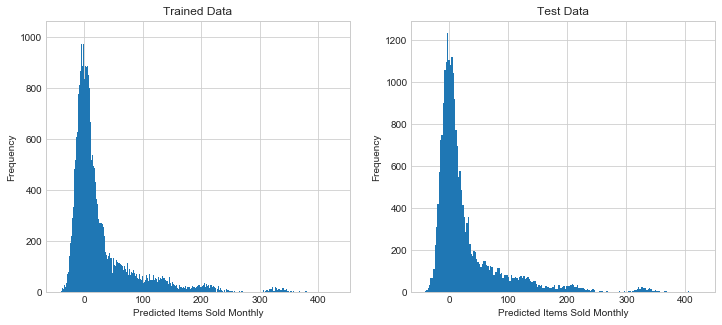

In [98]:
# Plot the predicted train and test values on histograms to observe the distribution

# Assign the predicted values to a variable
predicted_train_values = trained_linreg.predict(X_train)
predicted_test_values = trained_linreg.predict(X_test)

# Plot the histograms
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

# Plot the trained values
ax1.hist(predicted_train_values, bins=1000)
ax1.set_title('Trained Data')
ax1.set_xlabel('Predicted Items Sold Monthly')
ax1.set_ylabel('Frequency')

# Plot the test values
ax2.hist(predicted_test_values, bins=200)
ax2.set_title('Test Data')
ax2.set_xlabel('Predicted Items Sold Monthly')
ax2.set_ylabel('Frequency')

# Both data are right skewed

Text(0,0.5,'Predicted Monthly Items Sold')

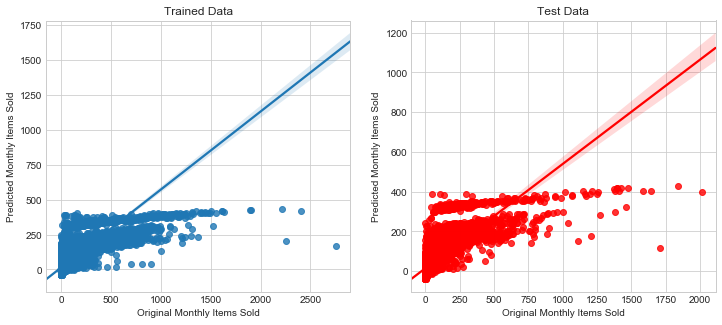

In [99]:
# Plot the original count vs. the predicted count of the training and test data on a scatter plot

# Plot the scatterplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

# Plot the trained values
sns.regplot(x=y_train, y=predicted_train_values, ax=ax1)
ax1.set_title('Trained Data')
ax1.set_xlabel('Original Monthly Items Sold')
ax1.set_ylabel('Predicted Monthly Items Sold')

# Plot the test values
sns.regplot(x=y_test, y=predicted_test_values, ax=ax2, color='r')
ax2.set_title('Test Data')
ax2.set_xlabel('Original Monthly Items Sold')
ax2.set_ylabel('Predicted Monthly Items Sold')

# It appears that our model has a tendency to underestimate. There appears to be a large amount of negative predictions

In [100]:
# Let's look at the RMSE and R^2 value for the model with the training data
trainRMSE = np.sqrt(mean_squared_error(y_train, predicted_train_values))

print ('Training Data    \nRoot Mean Squared Error:', trainRMSE)
print ('R^2:', trained_linreg.score(X_train, y_train))

Training Data    
Root Mean Squared Error: 55.57445182945994
R^2: 0.5590776303331422


In [101]:
# Let's look at the RMSE and R^2 value for the model with the test data
testRMSE = np.sqrt(mean_squared_error(y_test, predicted_test_values))

print ('Test Data    \nRoot Mean Squared Error:', testRMSE)
print ('R^2:', trained_linreg.score(X_test, y_test))

Test Data    
Root Mean Squared Error: 60.4460137864848
R^2: 0.551268237876264


In [102]:
# Let's look at the RMSE and R^2 value for the model using the baseline data at Jul 2014
baselinePrediction = trained_linreg.predict(baselineX)
baselineRMSE = np.sqrt(mean_squared_error(baseliney, baselinePrediction))

print ('Baseline Data    \nRoot Mean Squared Error:', baselineRMSE)
print ('R^2:', trained_linreg.score(baselineX, baseliney))

Baseline Data    
Root Mean Squared Error: 40.13526713281659
R^2: 0.578971303718814


In [103]:
# Alter the test data so that we can use it for testing

# Merge the item_category_id into the test data
test_cat = test.merge(items_df[['item_id', 'item_category_id']], on='item_id')


# Create the groupings in the data
test_cat_group = test_cat.merge(item_cat_concat, on='item_category_id')
test_cat_group= test_cat_group.merge(shop_concat, on='shop_id')
test_cat_group = test_cat_group.merge(grouped_item_df, on='item_id')

# Add the year and month column to the test data
test_cat_group['year'] = 2015
test_cat_group['month'] = 11

In [109]:
# For the model with grouped shop and item category
# test_df = test_cat_group[['year', 'month', 'Shop Group', 'Item Category Group']]

# For the model with only grouped item category
# test_df = test_cat_group[['year', 'month', 'shop_id', 'Item Category Group']]

# For the model with no groups
# test_df = test_cat_group[['year', 'month', 'shop_id', 'item_category_id']]

# For the model with grouped item ids
test_df = test_cat_group[['year', 'month', 'shop_id', 'item_group']]

In [110]:
# Create the dummy variables and remove the original column from the test data
for col in test_df:
    group_dummies = pd.get_dummies(test_df[col]).rename(columns=lambda x: col + str(x))
    test_df = test_df.join(group_dummies)
    del test_df[col]
    
# Add columns to the test data to use for prediction
for i in X_train:
    if i not in test_df:
        test_df[i] = 0
        
# Rearrange the columns
test_df = test_df[X_train.columns]

In [111]:
# Make the prediction for the double group and export it
# twoGroup = trained_linreg.predict(test_df)
# doubleGroup = pd.DataFrame(twoGroup, columns=['item_cnt_month'])
# doubleGroup.to_csv('Double_group_prediction.csv')


# Make a prediction for the item category group and export it
# singleGroup = trained_linreg.predict(test_df)
# oneGroup = pd.DataFrame(singleGroup, columns=['item_cnt_month'])
# oneGroup.to_csv('single_group_prediction.csv')


# Make a prediction for the no groups and export it
# noneGroup = trained_linreg.predict(test_df)
# noGroup = pd.DataFrame(noneGroup, columns=['item_cnt_month'])
# noGroup.to_csv('no_group_prediction.csv')


# Make a prediction for the grouped item_id and export it 
itemGroups = trained_linreg.predict(test_df)
itemID = pd.DataFrame(itemGroups, columns=['item_cnt_month'])
itemID.to_csv('group_itemID_prediction.csv')